In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import manify
import torch
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Instantiate product manifold

pm = manify.manifolds.ProductManifold(signature=[(-1, 2), (0, 2), (1, 2)])

# Polblogs + CoordinateLearning

In [4]:
# Try coordinate learning + polblogs

_, D, _, _ = manify.utils.dataloaders.load_hf("polblogs")

AttributeError: module 'manify' has no attribute 'utils'

In [5]:
cl = manify.embedders.coordinate_learning.CoordinateLearning(pm=pm)

In [7]:
test_indices = np.random.choice(np.arange(len(D)), size=5)
cl.fit(None, D=D, burn_in_iterations=10, training_iterations=90, test_indices=test_indices)

  0%|          | 0/100 [00:00<?, ?it/s]

CoordinateLearning(device='cpu',
                   pm=<manify.manifolds.ProductManifold object at 0x1284b07c0>)

In [9]:
# Should raise a warning, but still give you embeddings

cl.transform(None)

tensor([[ 1.5758,  1.1481,  0.4063,  ...,  0.9191, -0.2876, -0.2693],
        [ 1.0483, -0.1903, -0.2505,  ...,  0.7931, -0.6037,  0.0807],
        [ 1.7091,  0.5789,  1.2593,  ...,  0.4946, -0.1985,  0.8461],
        ...,
        [ 2.5285, -2.2552, -0.5541,  ..., -0.2014, -0.9790, -0.0327],
        [ 1.4045, -0.2872, -0.9435,  ...,  0.6689, -0.4117, -0.6190],
        [ 2.0760,  1.8189,  0.0407,  ...,  0.2590, -0.0993, -0.9608]])

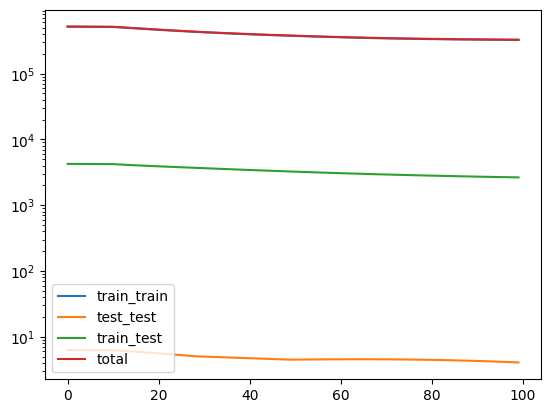

In [10]:
for key in cl.loss_history_.keys():
    plt.plot(cl.loss_history_[key], label=key)
plt.yscale("log")
plt.legend()

# MNIST + VAE

In [11]:
X, _, _, _ = manify.utils.dataloaders.load_hf("mnist")
X = X.reshape(-1, 28 * 28)

In [12]:
X.shape

torch.Size([60000, 784])

In [13]:
encoder = torch.nn.Sequential(torch.nn.Linear(784, 128), torch.nn.ReLU(), torch.nn.Linear(128, 2 * pm.dim))

decoder = torch.nn.Sequential(torch.nn.Linear(pm.ambient_dim, 128), torch.nn.Linear(128, 784), torch.nn.Sigmoid())

vae = manify.embedders.vae.ProductSpaceVAE(pm=pm, encoder=encoder, decoder=decoder)

In [14]:
vae.fit(X[:1024], training_iterations=1, batch_size=32)

  0%|          | 0/2048 [00:00<?, ?it/s]

ProductSpaceVAE(decoder=Sequential(
  (0): Linear(in_features=8, out_features=128, bias=True)
  (1): Linear(in_features=128, out_features=784, bias=True)
  (2): Sigmoid()
),
                encoder=Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=12, bias=True)
),
                pm=<manify.manifolds.ProductManifold object at 0x1284b07c0>)

In [15]:
vae.transform(X)

tensor([[ 0.7185, -2.2163,  0.6161,  0.1749, -9.4263,  3.9149],
        [ 0.4685, -0.5000,  1.1216,  0.3746, -4.8008,  2.7602],
        [ 0.5251, -0.6581,  0.1864,  0.3269, -2.6433,  1.4077],
        ...,
        [ 0.7673, -2.3843,  0.1607, -0.0302, -7.7846,  3.3065],
        [ 0.3775, -0.2647,  0.5063,  0.3055, -3.0530,  1.5099],
        [ 0.7585, -2.0651,  0.5893,  0.4627, -9.3052,  3.8369]])

# Qiita + Siamese

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import pickle
import manify
import torch
import matplotlib.pyplot as plt

with open("/Users/phil/Downloads/edit_qiita_large.pkl", "rb") as file:
    X, D = pickle.load(file)

In [32]:
# Let's do a little baby version
X_train = X["train"].float()
D_train = D["train"]
D_train /= D_train.max()

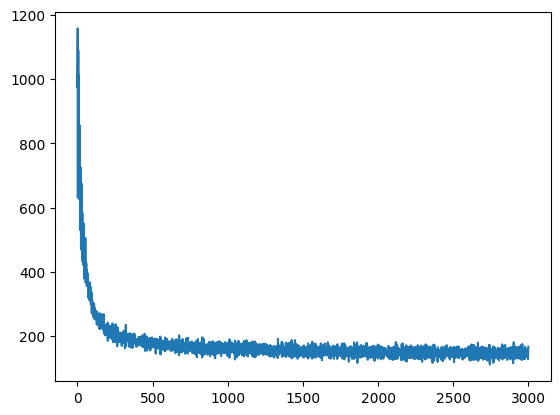

In [ ]:
# Super simple class
class SiameseNN(torch.nn.Module):
    def __init__(self, pm, encoder, decoder):
        super(SiameseNN, self).__init__()
        self.pm = pm
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, X1, X2):
        Z1 = self.pm.expmap(self.encoder(X1) @ self.pm.projection_matrix)
        Z2 = self.pm.expmap(self.encoder(X2) @ self.pm.projection_matrix)

        D_hat = self.pm.dist(Z1, Z2)

        Y1 = self.decoder(Z1)
        Y2 = self.decoder(Z2)

        return Z1, Z2, D_hat, Y1, Y2


# Training is weird because we need pairs of inputs
BETA = 1.0
EPOCHS = 1_000
BATCH_SIZE = 32
LR = 1e-4
n_samples = len(X_train)

# Let's train a network
pm = manify.ProductManifold(signature=[(-1, 2), (0, 2), (1, 2)])
d = X_train.shape[1]
encoder = torch.nn.Sequential(torch.nn.Linear(d, 128), torch.nn.ReLU(), torch.nn.Linear(128, pm.dim))
decoder = torch.nn.Sequential(torch.nn.Linear(pm.ambient_dim, 128), torch.nn.ReLU(), torch.nn.Linear(128, d))
model = SiameseNN(pm, encoder, decoder)
opt = torch.optim.Adam(params=model.parameters(), lr=LR)

# Track losses for monitoring
losses = []

for epoch in range(EPOCHS):
    epoch_loss = 0
    num_batches = 0

    # Randomly sample batch pairs instead of nested loop
    indices = torch.randperm(n_samples)
    indices2 = torch.randperm(n_samples)

    for i in range(0, n_samples, BATCH_SIZE):
        if i + BATCH_SIZE > n_samples:
            continue  # Skip incomplete last batch

        # Get first batch
        batch_indices1 = indices[i : i + BATCH_SIZE]
        X1 = X_train[batch_indices1]

        # Randomly sample second batch
        batch_indices2 = indices2[i : i + BATCH_SIZE]
        X2 = X_train[batch_indices2]

        # Get corresponding distance matrix for these specific indices
        D_batch = D_train[batch_indices1][:, batch_indices2]

        opt.zero_grad()
        _, _, D_hat, Y1, Y2 = model(X1, X2)

        mse1 = torch.nn.functional.mse_loss(Y1, X1)
        mse2 = torch.nn.functional.mse_loss(Y2, X2)
        distortion = manify.embedders._losses.distortion_loss(D_hat, D_batch, pairwise=False)

        L = mse1 + mse2 + BETA * distortion
        L.backward()
        opt.step()

        epoch_loss += L.item()
        num_batches += 1

        # print(L.item())
        losses.append(L.item())

plt.plot(losses)

# Upload Qiita to HuggingFace

In [ ]:
# # Upload GreenGenes to HuggingFace
# from huggingface_hub import login, whoami

# login(token="HF TOKEN")
# print(whoami)

# """
# make_hf_datasets.py
#  • loads each dataset via manify.utils.dataloaders.load
#  • wraps it into a single‑row HuggingFace Dataset
#  • pushes each one as its own HF repo under HF_NAMESPACE/<dataset_name>
# """

# import os
# import torch
# from datasets import Dataset

# # -----------------------------------------------------------------------------
# HF_NAMESPACE = os.getenv("HF_NAMESPACE", "manify")

# DATASETS = {
#     "qiita": dict(type="metric", task=None, has_adj=False),
# }
# # -----------------------------------------------------------------------------


# def to_py(x):
#     if x is None:
#         return []
#     if isinstance(x, torch.Tensor):
#         x = x.detach().cpu()
#     return x.tolist()


# def process(name: str) -> Dataset:
#     meta = DATASETS[name]
#     if meta["type"] == "distance":
#         dists, labels, adj = load(name)
#         feats = None
#     elif meta["type"] == "feature":
#         feats, labels, adj = load(name)
#         dists = None
#     elif meta["type"] == "metric":
#         feats, dists, labels, adj = X["train"], D["train"], None, None

#     row = {
#         "name": name,
#         "type": meta["type"],
#         "task": meta["task"] or "none",
#         "distances": to_py(dists),
#         "features": to_py(feats),
#         "adjacency": to_py(adj) if meta["has_adj"] else [],
#         "classification_labels": to_py(labels) if meta["task"] == "classification" else [],
#         "regression_labels": to_py(labels) if meta["task"] == "regression" else [],
#     }
#     # wrap each value in a list → one‑row Dataset
#     return Dataset.from_dict({k: [v] for k, v in row.items()})


# def main():
#     failed = []
#     for name in DATASETS:
#         print(f"→ processing {name}")
#         try:
#             ds = process(name)
#             repo_id = f"{HF_NAMESPACE}/{name}"
#             ds.push_to_hub(repo_id, private=False, num_shards=1)
#             print(f"✓ pushed to https://huggingface.co/datasets/{repo_id}")
#         except Exception as e:
#             print(f"✗ {name} failed: {e}")
#             failed.append(name)

#     if failed:
#         print(f"\n⚠️  {len(failed)} datasets failed:", failed)


# main()

<bound method HfApi.whoami of <huggingface_hub.hf_api.HfApi object at 0x38899bb20>>
→ processing qiita


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

✓ pushed to https://huggingface.co/datasets/manify/qiita


  0%|          | 0/191380 [00:00<?, ?it/s]

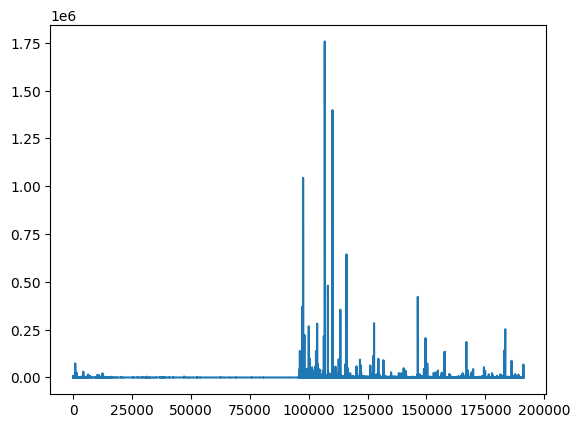

In [125]:
# load class
d = X["train"].shape[1]
pm = manify.manifolds.ProductManifold(signature=[(-1, 8), (0, 8), (1, 8)])

encoder = torch.nn.Sequential(
    torch.nn.Linear(d, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, pm.dim),
)
decoder = torch.nn.Sequential(
    torch.nn.Linear(pm.ambient_dim, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, d),
)

snn = manify.SiameseNetwork(pm=pm, encoder=encoder, decoder=decoder, beta=0.1)
snn.fit(
    # torch.nn.functional.one_hot(X["train"], num_classes=4).float().reshape(-1, d),
    X["train"].float(),
    D["train"] / D["train"].max(),
    burn_in_iterations=1,
    training_iterations=1,
    lr=1e-3,
    burn_in_lr=1e-4,
    batch_size=256,
    clip_grad=False,
    curvature_lr=1e-3,
)
plt.plot(snn.loss_history_["total"])

In [110]:
torch.nn.functional.one_hot(X["train"], num_classes=4).float().shape

torch.Size([7000, 152, 4])

In [103]:
torch.nn.functional.one_hot(X_train, num_classes=4)

RuntimeError: one_hot is only applicable to index tensor.

In [ ]:
z1 = snn.encode(X["train"][:32].float())
z2 = snn.encode(X["train"][32:64].float())

snn.pm.manifold.dist(snn.pm.expmap(z1 @ snn.pm.projection_matrix), snn.pm.expmap(z2 @ snn.pm.projection_matrix)).shape

torch.Size([32])